# M-PESA Statement Analysis

## 1. Load the necessary libraries

In [7]:
# Load necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pdfplumber
from utils import Utilities as utl
import warnings
warnings.filterwarnings('ignore')


# Load the dataset

In [2]:
file_path = "MPESA_Statement_2024-01-01_to_2024-12-24_2547xxxxxx374_unlocked.pdf"

# Extract table data from the PDF
with pdfplumber.open(file_path) as pdf:
    data = []
    for page in pdf.pages:
        table = page.extract_table()
        if table:
            data.extend(table)

# Set the appropriate column names for the dataframe
columns = ["Receipt No.", "Completion Time", "Details", "Transaction Status", "Paid In", "Withdrawn", "Balance"]
data = pd.DataFrame(data[1:], columns=columns)  # Skip header row from the data

# Display the first few rows of the dataset
data.head()

,Receipt No.,Completion Time,Details,Transaction Status,Paid In,Withdrawn,Balance
0,SLO4NDVHNM,2024-12-24 12:00:00,Customer Bundle Purchase to\n244441SAFARICOM P...,Completed,,-20.00,0.00
1,SLO2NDIE0O,2024-12-24 11:57:43,Funds received from -\n2547******312 JACKLINE\...,Completed,20.00,,20.00
2,SLO0N0O1ZC,2024-12-24 10:36:45,Pay Bill Charge,Completed,,-4.00,0.00
3,SLO0N0O1ZC,2024-12-24 10:36:45,Pay Bill Online to 290290 -\nBETIKA Acc. 25474...,Completed,,-25.00,4.00
4,SLN6KQ99C0,2024-12-23 18:44:00,Customer Transfer of Funds\nCharge,Completed,,-7.00,29.00


### Data Cleaning

In [3]:
import re

def clean_amount(amount):
    # Remove non-numeric characters except decimal points
    cleaned = re.sub(r'[^\d.]', '', str(amount))
    return cleaned

data['Paid In'] = data['Paid In'].apply(clean_amount)
data['Withdrawn'] = data['Withdrawn'].apply(clean_amount)
data['Balance'] = data['Balance'].apply(clean_amount)

# Check for missing values
data.isnull().sum()

Receipt No.           0
Completion Time       0
Details               0
Transaction Status    0
Paid In               0
Withdrawn             0
Balance               0
dtype: int64

# Data preprocessing

In [4]:
# Convert numeric columns to appropriate types
numeric_cols = ["Paid In", "Withdrawn", "Balance"]
for col in numeric_cols:
    data[col] = data[col].replace({',': '', ' ': ''}, regex=True)
    data[col] = pd.to_numeric(data[col], errors="coerce")

# Print basic information about the dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5029 entries, 0 to 5028
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Receipt No.         5029 non-null   object 
 1   Completion Time     5029 non-null   object 
 2   Details             5029 non-null   object 
 3   Transaction Status  5029 non-null   object 
 4   Paid In             1766 non-null   float64
 5   Withdrawn           3146 non-null   float64
 6   Balance             4912 non-null   float64
dtypes: float64(3), object(4)
memory usage: 275.1+ KB
None


In [24]:
# Ensure the column is in string format
data['Completion Time'] = data['Completion Time'].astype(str)

# Split the 'Completion Time' column into 'Date' and 'Time'
data[['Date', 'Time']] = data['Completion Time'].str.split(' ', expand=True)

# Dropping unnecessary columns
data.drop(columns=['Completion Time', 'Transaction Status'], inplace=True)
data.head(3)

,Receipt No.,Details,Paid In,Withdrawn,Balance,Date,Time
0,SLO4NDVHNM,Customer Bundle Purchase to\n244441SAFARICOM P...,NaN,20.0,0.0,2024-12-24,12:00:00
1,SLO2NDIE0O,Funds received from -\n2547******312 JACKLINE\...,20.0,NaN,20.0,2024-12-24,11:57:43
2,SLO0N0O1ZC,Pay Bill Charge,NaN,4.0,0.0,2024-12-24,10:36:45


In [25]:
data_copy = data.copy()
data.to_csv('data.csv', index=False)

# Feature engineering

### Function to filter rows based on multiple criterias

In [6]:
'''def filter_rows_by_multiple_criteria(transactions, criteria):
    import pandas as pd
    """
    Filters rows in a DataFrame based on multiple criteria. Returns rows that match any of the specified criteria.
    
    Parameters:
        transactions (pd.DataFrame): The input DataFrame to be filtered.
        criteria (dict): A dictionary where keys are column names and values are substrings (single string or list of strings).
    
    Returns:
        pd.DataFrame: A filtered DataFrame containing rows that match any of the specified criteria.
    """
    if not isinstance(criteria, dict):
        raise ValueError("Criteria must be provided as a dictionary with column names as keys and substrings as values.")
    
    # Initialize an empty filter (all False)
    combined_filter = pd.Series(False, index=transactions.index)
    
    # Loop through each column and corresponding substrings
    for column, substrings in criteria.items():
        if column not in transactions.columns:
            raise ValueError(f"Column '{column}' not found in the DataFrame.")
        
        # Handle single substring or list of substrings
        if isinstance(substrings, list):
            column_filter = transactions[column].apply(lambda x: any(sub in str(x) for sub in substrings))
        else:
            column_filter = transactions[column].str.contains(substrings, case=False, na=False)
        
        # Combine the current filter with the overall filter (logical OR)
        combined_filter |= column_filter
    
    # Apply the combined filter to the DataFrame
    return transactions[combined_filter]'''

'def filter_rows_by_multiple_criteria(transactions, criteria):\n    import pandas as pd\n    """\n    Filters rows in a DataFrame based on multiple criteria. Returns rows that match any of the specified criteria.\n    \n    Parameters:\n        transactions (pd.DataFrame): The input DataFrame to be filtered.\n        criteria (dict): A dictionary where keys are column names and values are substrings (single string or list of strings).\n    \n    Returns:\n        pd.DataFrame: A filtered DataFrame containing rows that match any of the specified criteria.\n    """\n    if not isinstance(criteria, dict):\n        raise ValueError("Criteria must be provided as a dictionary with column names as keys and substrings as values.")\n    \n    # Initialize an empty filter (all False)\n    combined_filter = pd.Series(False, index=transactions.index)\n    \n    # Loop through each column and corresponding substrings\n    for column, substrings in criteria.items():\n        if column not in transac

### Function to filter rows based on characters in a column

In [ ]:
'''# Function to filter rows based on characters in a column
def filter_rows_by_characters(transactions, column_name, substring):
    # Filter rows where the column contains the specified substring
    filtered_df = transactions[transactions[column_name].str.contains(substring, case=False, na=False)]
    return filtered_df'''

### Function for extracting phone numbers and names from rows.

In [8]:
'''def extract_transaction_details_inplace(df, details_column='Details', start_phrases=None):
    """
    Extracts phone numbers and names from rows in the specified column that start with given phrases.
    Adds the extracted data as new columns to the original DataFrame.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        details_column (str): The name of the column containing the transaction details.
        start_phrases (list): A list of phrases to filter rows (e.g., ["Funds received from", "Customer Transfer to"]).

    Returns:
        pd.DataFrame: The updated DataFrame with new columns 'Phone Number' and 'Name'.
    """
    if details_column not in df.columns:
        raise ValueError(f"Column '{details_column}' not found in the DataFrame.")
    
    if not start_phrases or not isinstance(start_phrases, list):
        raise ValueError("start_phrases must be a list of starting phrases (e.g., ['Funds received from']).")

    for phrase in start_phrases:
        # Filter rows starting with the specific phrase
        filtered_rows = df[details_column].str.startswith(phrase, na=False)

        # Extract phone numbers (including masked numbers with asterisks)
        phone_numbers = df.loc[filtered_rows, details_column].str.extract(
            r'(07\*{2,}\d{3}|2547\*{2,}\d{3}|\+2547\*{2,}\d{3}|07\d{8}|254\d{9}|\+254\d{9})'
        )[0]
        df.loc[filtered_rows, 'Phone Number'] = phone_numbers

        # Extract names based on the phrase
        if phrase == "Funds received from":
            names = df.loc[filtered_rows, details_column].str.extract(
                r'from\s-\s[\d\*\+]+\s([A-Za-z\s]+)'
            )[0]
        elif phrase == "Customer Transfer to":
            names = df.loc[filtered_rows, details_column].str.extract(
                r'to\s-\s[\d\*\+]+\s([A-Za-z\s]+)'
            )[0]
        else:
            names = None

        # Assign extracted names to the DataFrame
        df.loc[filtered_rows, 'Name'] = names

    return df'''

'def extract_transaction_details_inplace(df, details_column=\'Details\', start_phrases=None):\n    """\n    Extracts phone numbers and names from rows in the specified column that start with given phrases.\n    Adds the extracted data as new columns to the original DataFrame.\n\n    Parameters:\n        df (pd.DataFrame): The input DataFrame.\n        details_column (str): The name of the column containing the transaction details.\n        start_phrases (list): A list of phrases to filter rows (e.g., ["Funds received from", "Customer Transfer to"]).\n\n    Returns:\n        pd.DataFrame: The updated DataFrame with new columns \'Phone Number\' and \'Name\'.\n    """\n    if details_column not in df.columns:\n        raise ValueError(f"Column \'{details_column}\' not found in the DataFrame.")\n    \n    if not start_phrases or not isinstance(start_phrases, list):\n        raise ValueError("start_phrases must be a list of starting phrases (e.g., [\'Funds received from\']).")\n\n    for ph

### Obtaining funds received and sent

In [26]:
# Filter criteria
paid_in_criteria = {
    'Withdrawn': ['nan']
}
transfer_out_criteria = {
    'Paid In': ['nan']
}

In [27]:
# Received funds
paid_in_funds = utl.filter_rows_by_multiple_criteria(data_copy, paid_in_criteria)
print(paid_in_funds.head())

   Receipt No.                                            Details  Paid In  \
1   SLO2NDIE0O  Funds received from -\n2547******312 JACKLINE\...     20.0   
6   SLN7KQ3LF7                                  M-Shwari Withdraw    250.0   
8   SLN7KH7QC5  Promotion Payment from 763552\n- BETIKA B2C vi...     70.0   
12  SLN9KAY4QF  Promotion Payment from 763552\n- BETIKA B2C vi...    100.0   
16  SLN0JN219Q  Funds received from -\n07******928 Shallon Man...    100.0   

    Withdrawn  Balance        Date      Time  
1         NaN     20.0  2024-12-24  11:57:43  
6         NaN    286.0  2024-12-23  18:43:16  
8         NaN     86.0  2024-12-23  17:58:54  
12        NaN    600.0  2024-12-23  17:24:43  
16        NaN    606.0  2024-12-23  14:54:10  


In [28]:
# Transfered funds
transfer_out_funds = utl.filter_rows_by_multiple_criteria(data_copy, transfer_out_criteria)
print(transfer_out_funds.head())

  Receipt No.                                            Details  Paid In  \
0  SLO4NDVHNM  Customer Bundle Purchase to\n244441SAFARICOM P...      NaN   
2  SLO0N0O1ZC                                    Pay Bill Charge      NaN   
3  SLO0N0O1ZC  Pay Bill Online to 290290 -\nBETIKA Acc. 25474...      NaN   
4  SLN6KQ99C0                 Customer Transfer of Funds\nCharge      NaN   
5  SLN6KQ99C0  Customer Transfer to -\n07******179 Sharon che...      NaN   

   Withdrawn  Balance        Date      Time  
0       20.0      0.0  2024-12-24  12:00:00  
2        4.0      0.0  2024-12-24  10:36:45  
3       25.0      4.0  2024-12-24  10:36:45  
4        7.0     29.0  2024-12-23  18:44:00  
5      250.0     36.0  2024-12-23  18:44:00  


In [29]:
total_received = paid_in_funds['Paid In'].sum()
print(f'Total incoming funds: ksh {total_received}')

Total incoming funds: ksh 259667.0


In [30]:
total_transfered = transfer_out_funds['Withdrawn'].sum()
print(f'Total outgoing funds: ksh {total_transfered}')

Total outgoing funds: ksh 260462.0


## Saving receipts and transfers in file

In [31]:
paid_in_funds.to_csv('paid_in_funds.csv', index = False)

In [32]:
transfer_out_funds.to_csv('transfer_out_funds.csv', index = False)

# Receipts processing

## Funds received through send money

In [33]:
received = pd.read_csv('paid_in_funds.csv')

## Funds received by sent money search filter

In [34]:
received_from_sent_money = utl.filter_rows_by_characters(received, 'Details', 'funds received from')

In [35]:
# Group by 'Details' to see total withdrawn per recipient/merchant
received_grouped_by_details = received_from_sent_money.groupby('Details').agg({'Paid In': 'sum'}).sort_values(by='Paid In', ascending=False)
print(received_grouped_by_details.head(20))

                                                    Paid In
Details                                                    
Funds received from -\n07******305 NOAH CHIRCHIR    40660.0
Funds received from -\n2547******231 MERCY KORIR    39610.0
Funds received from -\n2547******222 noah chirchir  18731.0
Funds received from -\n2547******295 KIPROTICH\...   4800.0
Funds received from -\n07******928 Shallon Mangera   4400.0
Funds received from -\n2547******069 Vincent Tonui   4270.0
Funds received from -\n07******849 Mercy Chepkoech   2520.0
Funds received from -\n07******873 Chelang'at K...   2470.0
Funds received from -\n2547******070 ROSE\nCHEP...   2200.0
Funds received from -\n2547******992 EMMANUEL\n...   2170.0
Funds received from -\n07******392 edna nyole        2100.0
Funds received from -\n2547******712 CHEPKIRUI\...   2020.0
Funds received from -\n2547******208 Goldby Nya...   1945.0
Funds received from -\n2547******331 Terer Benj...   1530.0
Funds received from -\n2547******347 BEN

### Extracting name and phone number columns

In [36]:
# Applying the function
start_phrases = ["Funds received from"]
extract_df = utl.extract_transaction_details_inplace(received_from_sent_money, start_phrases=start_phrases)

In [21]:
extract_df.head(3)

,Receipt No.,Completion Time,Details,Transaction Status,Paid In,Withdrawn,Balance,Phone Number,Name
0,SLO2NDIE0O,2024-12-24 11:57:43,Funds received from -\n2547******312 JACKLINE\...,Completed,20.0,NaN,20.0,2547******312,JACKLINE\nCHEPKOECH
4,SLN0JN219Q,2024-12-23 14:54:10,Funds received from -\n07******928 Shallon Man...,Completed,100.0,NaN,606.0,07******928,Shallon Mangera
5,SLN8J4BBG2,2024-12-23 12:53:46,Funds received from -\n2547******330 GLADYS\nC...,Completed,500.0,NaN,506.0,2547******330,GLADYS\nCHELANGAT


In [37]:
# Drop the original 'Details' and 'Withdrawn' columns because they are no longer needed
extract_df.drop(columns=['Details', 'Withdrawn', 'Balance'], errors='ignore', inplace=True)
extract_df.head(3)

,Receipt No.,Paid In,Date,Time,Phone Number,Name
0,SLO2NDIE0O,20.0,2024-12-24,11:57:43,2547******312,JACKLINE\nCHEPKOECH
4,SLN0JN219Q,100.0,2024-12-23,14:54:10,07******928,Shallon Mangera
5,SLN8J4BBG2,500.0,2024-12-23,12:53:46,2547******330,GLADYS\nCHELANGAT


In [38]:
# Specify the desired column order
desired_order = ['Receipt No.', 'Date', 'Time', 'Phone Number', 'Name', 'Paid In']

# Reorder the DataFrame
extract_df = extract_df[desired_order]
extract_df.head(3)

,Receipt No.,Date,Time,Phone Number,Name,Paid In
0,SLO2NDIE0O,2024-12-24,11:57:43,2547******312,JACKLINE\nCHEPKOECH,20.0
4,SLN0JN219Q,2024-12-23,14:54:10,07******928,Shallon Mangera,100.0
5,SLN8J4BBG2,2024-12-23,12:53:46,2547******330,GLADYS\nCHELANGAT,500.0


In [39]:
extract_df.shape

(1097, 6)

In [40]:
# save processed data into a csv file
extract_df.to_csv('cleaned_received.csv', index=False)

In [41]:
clean_received = pd.read_csv('cleaned_received.csv')

In [42]:
# Sort the dataframe by paid in and date
clean_received_sorted = clean_received.sort_values(by=['Paid In', 'Date'], ascending=[False, False])
clean_received_sorted.head(10)

,Receipt No.,Date,Time,Phone Number,Name,Paid In
1022,SD99MIE6HH,2024-04-09,12:30:50,07******305,NOAH CHIRCHIR,12300.0
751,SI45FN1YOD,2024-09-04,18:50:44,2547******295,KIPROTICH\nLANGAT,4000.0
800,SHN92N53W9,2024-08-23,19:32:30,2547******231,MERCY KORIR,4000.0
84,SL468LDD7O,2024-12-04,19:49:40,2547******222,noah chirchir,3500.0
773,SHS3KTGD0Z,2024-08-28,13:44:34,2547******231,MERCY KORIR,3300.0
725,SIB77D0JRL,2024-09-11,11:27:33,2547******231,MERCY KORIR,3200.0
874,SGC1H2K0K7,2024-07-12,19:54:59,2547******231,MERCY KORIR,3200.0
284,SKB0EXAB6G,2024-11-11,14:25:38,07******928,Shallon Mangera,3000.0
633,SIQ2XWAY76,2024-09-26,18:31:28,2547******231,MERCY KORIR,3000.0
39,SLE4FCUDDG,2024-12-14,12:18:42,2547******222,noah chirchir,2300.0


In [43]:
clean_received_sorted.to_csv('clean_received_sorted.csv')

In [44]:
# Group by Name, phone number to see total paid in per recipient/merchant
received_grouped_by_phone_number = clean_received.groupby(['Name','Phone Number']).agg({'Paid In': 'sum'}).sort_values(by='Paid In', ascending=False)
print(received_grouped_by_phone_number.head(20))

                                   Paid In
Name                Phone Number          
NOAH CHIRCHIR       07******305    40660.0
MERCY KORIR         2547******231  39610.0
noah chirchir       2547******222  18731.0
KIPROTICH\nLANGAT   2547******295   4800.0
Shallon Mangera     07******928     4400.0
Vincent Tonui       2547******069   4270.0
Mercy Chepkoech     07******849     2520.0
Chelang             07******873     2470.0
ROSE\nCHEPKWONY     2547******070   2200.0
EMMANUEL\nKIPKIRUI  2547******992   2170.0
edna nyole          07******392     2100.0
CHEPKIRUI\nJOSPHINE 2547******712   2020.0
Goldby Nyamora      2547******208   1945.0
Terer Benjamin      2547******331   1530.0
BENARD SIELE        2547******347   1471.0
GLADYS\nCHELANGAT   2547******330   1465.0
Edna Nyole          2547******593   1354.0
MERCY CHERONO       07******430     1238.0
Benard Siele        07******459     1119.0
EVANS KORIR         2547******720   1100.0


In [45]:
# Saving grouped receipts by phone number
received_grouped_by_phone_number.to_csv('received_grouped_by_phone_number.csv')

# Transfers processing

## Transfers by send money

In [46]:
transfered = pd.read_csv('transfer_out_funds.csv')

## Funds transfer search filter

In [47]:
transfer_by_send_money = utl.filter_rows_by_characters(transfered, 'Details', 'customer transfer to')

## Funds transfered through send money

In [48]:
# Group by 'Details' to see total withdrawn per recipient/merchant
transfer_grouped_by_details = transfer_by_send_money.groupby('Details').agg({'Withdrawn': 'sum'}).sort_values(by='Withdrawn', ascending=False)
print(transfer_grouped_by_details.head(10))

                                                    Withdrawn
Details                                                      
Customer Transfer to -\n2547******589 JANES\nNY...     6140.0
Customer Transfer to -\n07******179 Sharon cheptoo     5645.0
Customer Transfer to -\n2547******724 KIPNGENO ...     4455.0
Customer Transfer to -\n2547******069 Vincent T...     4294.0
Customer Transfer to -\n07******430 MERCY CHERONO      4255.0
Customer Transfer to -\n2547******320 Collins K...     3412.0
Customer Transfer to -\n2547******593 Edna Nyole       3035.0
Customer Transfer to -\n07******849 Mercy Chepk...     2650.0
Customer Transfer to -\n2547******312 JACKLINE\...     2650.0
Customer Transfer to -\n2547******992 EMMANUEL\...     2320.0


In [50]:
start_phrases = ["Customer Transfer to"]
transfer_df = utl.extract_transaction_details_inplace(transfer_by_send_money, start_phrases=start_phrases)
transfer_df.head(3)

,Receipt No.,Details,Paid In,Withdrawn,Balance,Date,Time,Phone Number,Name
4,SLN6KQ99C0,Customer Transfer to -\n07******179 Sharon che...,NaN,250.0,36.0,2024-12-23,18:44:00,07******179,Sharon cheptoo
18,SLM0GXACT0,Customer Transfer to -\n2547******992 EMMANUEL...,NaN,20.0,57.0,2024-12-22,20:09:34,2547******992,EMMANUEL\nKIPKIRUI
19,SLM9GOA1JJ,Customer Transfer to -\n2547******571 BETTY CH...,NaN,40.0,77.0,2024-12-22,19:26:05,2547******571,BETTY CHERUYOT


In [51]:
# Drop the original 'Details' and 'Transaction Status' columns because they are no longer needed
transfer_df.drop(columns=['Details', 'Paid In'], errors='ignore', inplace=True)
transfer_df.head(3)

,Receipt No.,Withdrawn,Balance,Date,Time,Phone Number,Name
4,SLN6KQ99C0,250.0,36.0,2024-12-23,18:44:00,07******179,Sharon cheptoo
18,SLM0GXACT0,20.0,57.0,2024-12-22,20:09:34,2547******992,EMMANUEL\nKIPKIRUI
19,SLM9GOA1JJ,40.0,77.0,2024-12-22,19:26:05,2547******571,BETTY CHERUYOT


In [52]:
# Specify the desired column order
desired_order = ['Receipt No.', 'Date', 'Time', 'Phone Number', 'Name', 'Withdrawn']

# Reorder the DataFrame
transfer_df = transfer_df[desired_order]
transfer_df.head(3)

,Receipt No.,Date,Time,Phone Number,Name,Withdrawn
4,SLN6KQ99C0,2024-12-23,18:44:00,07******179,Sharon cheptoo,250.0
18,SLM0GXACT0,2024-12-22,20:09:34,2547******992,EMMANUEL\nKIPKIRUI,20.0
19,SLM9GOA1JJ,2024-12-22,19:26:05,2547******571,BETTY CHERUYOT,40.0


In [53]:
transfer_df.shape

(1072, 6)

In [54]:
# save processed data into a csv file
transfer_df.to_csv('cleaned_transfered.csv', index=False)

In [55]:
clean_transfered = pd.read_csv('cleaned_transfered.csv')

In [56]:
# Sort the dataframe by paid in and date
clean_transfered_sorted = clean_transfered.sort_values(by=['Withdrawn', 'Date'], ascending=[False, False])
clean_transfered_sorted.head(10)

,Receipt No.,Date,Time,Phone Number,Name,Withdrawn
794,SF70P46LPO,2024-06-07,11:55:46,07******849,Mercy Chepkoech,1550.0
966,SD94NUVWWG,2024-04-09,18:26:07,07******438,HILLARY ROTICH,1450.0
259,SK20AEOZQG,2024-11-02,10:30:55,07******430,MERCY CHERONO,1300.0
667,SGR12CA345,2024-07-27,19:18:07,2547******741,Bishara Nunow,1200.0
87,SL76M10KU8,2024-12-07,19:17:54,2547******231,MERCY KORIR,1000.0
242,SK925VH3FG,2024-11-09,11:16:39,07******301,Jackline Onyancha,1000.0
740,SFT92B0UID,2024-06-29,20:12:01,07******849,Mercy Chepkoech,1000.0
914,SDJ4OUACF8,2024-04-19,18:30:03,2547******951,Philip Embenzi,1000.0
971,SD96MK2TA8,2024-04-09,12:44:34,2547******320,Collins Kipkorir,1000.0
972,SD91MJXRM3,2024-04-09,12:43:22,2547******320,Collins Kipkorir,1000.0


In [57]:
clean_transfered_sorted.to_csv('clean_transfered_sorted.csv')

In [58]:
# Group by Name, phone number to see total paid in per recipient/merchant
transfered_grouped_by_phone_number = clean_transfered.groupby(['Name','Phone Number']).agg({'Withdrawn': 'sum'}).sort_values(by='Withdrawn', ascending=False)
print(transfered_grouped_by_phone_number.head(20))

                                   Withdrawn
Name                Phone Number            
JANES\nNYAMONGO     2547******589     6140.0
Sharon cheptoo      07******179       5645.0
KIPNGENO SIGEI      2547******724     4455.0
Vincent Tonui       2547******069     4294.0
MERCY CHERONO       07******430       4255.0
Collins Kipkorir    2547******320     3412.0
Edna Nyole          2547******593     3035.0
Mercy Chepkoech     07******849       2650.0
JACKLINE\nCHEPKOECH 2547******312     2650.0
EMMANUEL\nKIPKIRUI  2547******992     2320.0
noah chirchir       2547******222     2010.0
HARON MOGARU        07******620       1789.0
edna nyole          07******392       1780.0
Aron rotich         2547******149     1520.0
MERCY KORIR         2547******231     1500.0
HILLARY ROTICH      07******438       1450.0
JOHN KOBEI          2547******181     1240.0
Bishara Nunow       2547******741     1200.0
Judy Bosuben        07******311       1020.0
Goldby Nyamora      2547******208     1020.0


In [59]:
transfered_grouped_by_phone_number.to_csv('transfered_grouped_by_phone_number.csv')

# Direct deposits

In [99]:
deposits = utl.filter_rows_by_characters(received, 'Details', 'deposit of funds')
deposits.head(3)

,Receipt No.,Details,Paid In,Withdrawn,Balance,Date,Time
66,SLF6M02OPS,Deposit of Funds at Agent Till\n779076 - SEMIG...,100.0,NaN,194.0,2024-12-15,21:32:48
81,SLE4HUFJ9E,Deposit of Funds at Agent Till\n779076 - SEMIG...,600.0,NaN,700.0,2024-12-14,20:58:42
87,SLE4H56ORA,Deposit of Funds at Agent Till\n135809 - Davis...,50.0,NaN,100.0,2024-12-14,19:01:52


In [100]:
deposits.shape

(46, 7)

In [101]:
deposits.to_csv('direct_deposits.csv')

In [102]:
direct_deposits = pd.read_csv('direct_deposits.csv')

In [103]:
direct_deposits = utl.extract_till_and_agent(direct_deposits, 'Details')
direct_deposits.head()

,Unnamed: 0,Receipt No.,Details,Paid In,Withdrawn,Balance,Date,Time,Agent Till,Agent Name
0,66,SLF6M02OPS,Deposit of Funds at Agent Till\n779076 - SEMIG...,100.0,NaN,194.0,2024-12-15,21:32:48,779076,SEMIGRAN COMM ENTS
1,81,SLE4HUFJ9E,Deposit of Funds at Agent Till\n779076 - SEMIG...,600.0,NaN,700.0,2024-12-14,20:58:42,779076,SEMIGRAN COMM ENTS
2,87,SLE4H56ORA,Deposit of Funds at Agent Till\n135809 - Davis...,50.0,NaN,100.0,2024-12-14,19:01:52,135809,Daviski Co Chekwa
3,109,SLD7C1YS2P,Deposit of Funds at Agent Till\n135809 - Davis...,300.0,NaN,314.0,2024-12-13,16:30:05,135809,Daviski Co Chekwa
4,132,SLB61XYQOI,Deposit of Funds at Agent Till\n779076 - SEMIG...,205.0,NaN,225.0,2024-12-11,10:24:36,779076,SEMIGRAN COMM ENTS


In [104]:
direct_deposits = direct_deposits.drop(columns = ['Details', 'Withdrawn', 'Balance', 'Unnamed: 0'], errors = 'ignore')

In [105]:
column_order = ['Receipt No.', 'Date', 'Time', 'Agent Till', 'Agent Name', 'Paid In']
direct_deposits = direct_deposits[column_order]
direct_deposits.head()

,Receipt No.,Date,Time,Agent Till,Agent Name,Paid In
0,SLF6M02OPS,2024-12-15,21:32:48,779076,SEMIGRAN COMM ENTS,100.0
1,SLE4HUFJ9E,2024-12-14,20:58:42,779076,SEMIGRAN COMM ENTS,600.0
2,SLE4H56ORA,2024-12-14,19:01:52,135809,Daviski Co Chekwa,50.0
3,SLD7C1YS2P,2024-12-13,16:30:05,135809,Daviski Co Chekwa,300.0
4,SLB61XYQOI,2024-12-11,10:24:36,779076,SEMIGRAN COMM ENTS,205.0


In [106]:
direct_deposits.to_csv('clean_direct_deposits.csv')

In [107]:
# Group by 'Details' to see total withdrawn per recipient/merchant
deposits_grouped_by_details = direct_deposits.groupby(['Agent Name','Agent Till']).agg({'Paid In': 'sum'}).sort_values(by='Paid In', ascending=False)
print(deposits_grouped_by_details)

                                   Paid In
Agent Name             Agent Till         
SEMIGRAN COMM ENTS     779076       4155.0
Daviski Co Chekwa      135809       2510.0
Bayt construction      374133       1075.0
PHONELAND              636258        700.0
Semigran Comm Ents     779066        610.0
Wapcom Limited Angie   235459        555.0
EUNITE PRIDE K LTD     2049164       250.0
Brigidi Holdings Ltd   495479        210.0
Purona Services        173422        150.0
Biston Emporium sami   061801        100.0
Prestige Tea Buying Co 299613        100.0
TOP GEAR COMM LTD      2164063       100.0


In [108]:
deposits_grouped_by_details.to_csv('direct_deposits_grouped_by_details.csv')

# M-shwari withdrawals

In [110]:
mshwari_withdrawals = utl.filter_rows_by_characters(received, 'Details', 'M-shwari')
mshwari_withdrawals.head(10)

,Receipt No.,Details,Paid In,Withdrawn,Balance,Date,Time
1,SLN7KQ3LF7,M-Shwari Withdraw,250.0,NaN,286.0,2024-12-23,18:43:16
6,SLN2J0JB3A,M-Shwari Withdraw,50.0,NaN,50.0,2024-12-23,12:29:15
7,SLN7IUKEOV,M-Shwari Lock Withdraw to\nSavings,0.0,NaN,0.0,2024-12-23,11:49:55
9,SLM1GCIMI5,M-Shwari Withdraw,200.0,NaN,200.0,2024-12-22,18:28:41
11,SLM4EJNNW8,M-Shwari Withdraw,20.0,NaN,420.0,2024-12-22,11:03:08
14,SLM0EE51ME,M-Shwari Withdraw,30.0,NaN,30.0,2024-12-22,10:18:59
15,SLL7D9DPFH,M-Shwari Lock Withdraw to\nSavings,0.0,NaN,22.0,2024-12-21,21:40:28
16,SLL4CBVOUG,M-Shwari Lock Withdraw to\nSavings,0.0,NaN,112.0,2024-12-21,18:48:26
18,SLL8BBNCME,M-Shwari Withdraw,500.0,NaN,502.0,2024-12-21,15:19:52
20,SLL4A2M9YM,M-Shwari Withdraw,100.0,NaN,100.0,2024-12-21,10:16:29


In [111]:
mshwari_withdrawals.shape

(515, 7)

In [112]:
# Group by Name, phone number to see total paid in per recipient/merchant
mshwari_withdrawals_grouped_by_details = mshwari_withdrawals.groupby(['Date', 'Time']).agg({'Paid In': 'sum'}).sort_values(by='Paid In', ascending=False)
print(mshwari_withdrawals_grouped_by_details.head(20))

                     Paid In
Date       Time             
2024-04-10 19:50:27   3500.0
2024-11-11 14:34:25   3000.0
2024-12-14 12:05:48   2250.0
2024-10-22 16:17:55   2150.0
2024-12-06 13:58:08   2000.0
2024-10-11 20:39:40   1200.0
2024-04-19 18:28:50   1010.0
2024-05-08 09:16:15    900.0
2024-03-12 11:44:19    830.0
2024-10-11 13:46:35    800.0
2024-05-30 14:57:21    750.0
2024-06-01 10:30:21    650.0
2024-12-09 16:25:25    550.0
2024-10-18 15:13:11    550.0
2024-04-06 19:18:52    530.0
2024-03-12 10:35:05    530.0
2024-12-21 15:19:52    500.0
2024-07-24 16:57:05    500.0
2024-10-30 08:24:20    490.0
2024-07-17 19:22:42    480.0


In [113]:
total_mshwari_withdrawals = mshwari_withdrawals['Paid In'].sum()
print(f'Your total M-shwari withdrawals is Ksh.{total_mshwari_withdrawals}')

Your total M-shwari withdrawals is Ksh.59276.0


In [114]:
mshwari_withdrawals.to_csv('mshwari_withdrawals.csv')

# M-shwari deposits

In [116]:
mshwari_deposits = utl.filter_rows_by_characters(transfered, 'Details', 'M-shwari')
mshwari_deposits.head(10)

,Receipt No.,Details,Paid In,Withdrawn,Balance,Date,Time
5,SLN9KM0NHR,M-Shwari Deposit,NaN,50.0,36.0,2024-12-23,18:23:37
8,SLN0KD2XJS,M-Shwari Deposit,NaN,550.0,50.0,2024-12-23,17:36:37
55,SLL9A4W5MB,M-Shwari Deposit,NaN,500.0,70.0,2024-12-21,10:32:30
111,SLH6U8UN0A,M-Shwari Deposit,NaN,100.0,116.0,2024-12-17,20:06:27
179,SLE3HUX9B3,M-Shwari Deposit,NaN,600.0,90.0,2024-12-14,21:01:31
188,SLE2GYT5LC,M-Shwari Deposit,NaN,150.0,50.0,2024-12-14,18:32:29
202,SLE4G1ME4W,M-Shwari Deposit,NaN,450.0,94.0,2024-12-14,15:06:15
207,SLE6FHT2JE,M-Shwari Deposit,NaN,70.0,1.0,2024-12-14,12:52:37
208,SLE7FE70N3,M-Shwari Deposit,NaN,2150.0,71.0,2024-12-14,12:28:02
219,SLD4D18GWO,M-Shwari Deposit,NaN,150.0,70.0,2024-12-13,19:33:16


In [117]:
mshwari_deposits.shape

(172, 7)

In [118]:
# Group by Name, phone number to see total paid in per recipient/merchant
mshwari_deposits_grouped_by_details = mshwari_deposits.groupby(['Date', 'Time']).agg({'Withdrawn': 'sum'}).sort_values(by='Withdrawn', ascending=False)
print(mshwari_deposits_grouped_by_details.head(20))

                     Withdrawn
Date       Time               
2024-04-10 08:35:49     6000.0
2024-11-11 14:26:44     3000.0
2024-12-04 19:51:25     3000.0
2024-09-04 19:26:45     2900.0
2024-10-18 17:18:22     2250.0
2024-12-14 12:28:02     2150.0
2024-10-10 22:53:52     1450.0
2024-01-10 17:46:15     1000.0
2024-09-28 00:59:53     1000.0
2024-11-23 19:46:08     1000.0
2024-03-05 22:21:39     1000.0
2024-07-12 18:01:14      800.0
2024-06-26 19:06:52      800.0
2024-05-30 15:00:18      750.0
2024-03-06 13:12:58      700.0
2024-05-19 11:27:48      700.0
2024-12-04 17:34:30      670.0
2024-06-07 01:26:17      600.0
2024-06-01 12:46:53      600.0
2024-12-14 21:01:31      600.0


In [119]:
total_mshwari_deposits = mshwari_deposits['Withdrawn'].sum()
print(f'Your total M-shwari deposits is Ksh.{total_mshwari_deposits}')

Your total M-shwari deposits is Ksh.60369.0


In [120]:
mshwari_deposits.to_csv('mshwari_deposits.csv')

# Business Payment

In [122]:
business_payment = utl.filter_rows_by_characters(received, 'Details', 'Acc')
business_payment.head(10)

,Receipt No.,Details,Paid In,Withdrawn,Balance,Date,Time
219,SL34185PB4,Business Payment from 300600 -\nEquity Bulk Ac...,100.0,NaN,100.0,2024-12-03,09:18:40
478,SKE4RRZ92Y,Business Payment from 300600 -\nEquity Bulk Ac...,80.0,NaN,82.0,2024-11-14,15:58:07
495,SKD5NN6Q7P,Business Payment from 300600 -\nEquity Bulk Ac...,60.0,NaN,87.0,2024-11-13,16:03:05
525,SKB6DESMHM,Business Payment from 300600 -\nEquity Bulk Ac...,200.0,NaN,365.0,2024-11-11,07:12:21
560,SK69S6UIYX,Business Payment from 300600 -\nEquity Bulk Ac...,150.0,NaN,186.0,2024-11-06,13:23:28
574,SK59OH1SGX,Business Payment from 300600 -\nEquity Bulk Ac...,1030.0,NaN,1040.0,2024-11-05,15:57:09
853,SJA0NJ1KNO,Business Payment from 300600 -\nEquity Bulk Ac...,1500.0,NaN,1500.0,2024-10-10,22:49:44
1861,SAA6MM4WCO,Business Payment from 300600 -\nEquity Bulk Ac...,500.0,NaN,502.0,2024-01-10,15:51:50


In [123]:
business_payment.shape

(8, 7)

In [124]:
# Group by Name, phone number to see total paid in per recipient/merchant
business_payment_grouped_by_details = business_payment.groupby(['Details','Date', 'Time']).agg({'Paid In': 'sum'}).sort_values(by='Paid In', ascending=False)
print(business_payment_grouped_by_details.head(20))

                                                                        Paid In
Details                                            Date       Time             
Business Payment from 300600 -\nEquity Bulk Acc... 2024-10-10 22:49:44   1500.0
Business Payment from 300600 -\nEquity Bulk Acc... 2024-11-05 15:57:09   1030.0
Business Payment from 300600 -\nEquity Bulk Acc... 2024-01-10 15:51:50    500.0
Business Payment from 300600 -\nEquity Bulk Acc... 2024-11-11 07:12:21    200.0
Business Payment from 300600 -\nEquity Bulk Acc... 2024-11-06 13:23:28    150.0
Business Payment from 300600 -\nEquity Bulk Acc... 2024-12-03 09:18:40    100.0
Business Payment from 300600 -\nEquity Bulk Acc... 2024-11-14 15:58:07     80.0
Business Payment from 300600 -\nEquity Bulk Acc... 2024-11-13 16:03:05     60.0


In [125]:
business_payment_grouped_by_details.to_csv('business_payments.csv')

# Promotion payments

In [126]:
promotion_payments = utl.filter_rows_by_characters(received, 'Details', 'promotion')
promotion_payments.head(10)

,Receipt No.,Details,Paid In,Withdrawn,Balance,Date,Time
2,SLN7KH7QC5,Promotion Payment from 763552\n- BETIKA B2C vi...,70.0,NaN,86.0,2024-12-23,17:58:54
3,SLN9KAY4QF,Promotion Payment from 763552\n- BETIKA B2C vi...,100.0,NaN,600.0,2024-12-23,17:24:43
12,SLM4EIIFA4,Promotion Payment from 763552\n- BETIKA B2C vi...,200.0,NaN,400.0,2024-12-22,10:53:53
13,SLM3EHBIQR,Promotion Payment from 763552\n- BETIKA B2C vi...,200.0,NaN,200.0,2024-12-22,10:44:23
22,SLK08NEXP2,Promotion Payment from 763552\n- BETIKA B2C vi...,100.0,NaN,105.0,2024-12-20,20:56:29
42,SLH2UJH812,Promotion Payment from 763552\n- BETIKA B2C vi...,100.0,NaN,100.0,2024-12-17,21:00:21
59,SLG6O3KVTE,Promotion Payment from 763552\n- BETIKA B2C vi...,100.0,NaN,190.0,2024-12-16,13:59:46
89,SLE8GTYPFO,Promotion Payment from 763552\n- BETIKA B2C vi...,200.0,NaN,200.0,2024-12-14,18:07:08
152,SL84R7T0YW,Promotion Payment from 763552\n- BETIKA B2C vi...,380.0,NaN,390.0,2024-12-08,23:08:44
155,SL84Q9UF6S,Promotion Payment from 763552\n- BETIKA B2C vi...,100.0,NaN,100.0,2024-12-08,19:17:28


In [127]:
promotion_payments.shape

(39, 7)

In [128]:
# Group by Name, phone number to see total paid in per recipient/merchant
promotion_payments_grouped_by_details = promotion_payments.groupby(['Details','Date', 'Time']).agg({'Paid In': 'sum'}).sort_values(by='Paid In', ascending=False)
print(promotion_payments_grouped_by_details.head(10))

                                                                        Paid In
Details                                            Date       Time             
Promotion Payment from 763552\n- BETIKA B2C via... 2024-11-29 14:59:20    620.0
Promotion Payment from 763552\n- BETIKA B2C via... 2024-11-16 01:36:58    600.0
Promotion Payment from 763552\n- BETIKA B2C via... 2024-12-08 23:08:44    380.0
Promotion Payment from 763552\n- BETIKA B2C via... 2024-08-25 10:47:24    288.0
Promotion Payment from 763552\n- BETIKA B2C via... 2024-10-13 05:42:09    240.0
Promotion Payment from 763552\n- BETIKA B2C via... 2024-12-22 10:53:53    200.0
Promotion Payment from 763552\n- BETIKA B2C via... 2024-12-22 10:44:23    200.0
Promotion Payment from 763552\n- BETIKA B2C via... 2024-12-14 18:07:08    200.0
Promotion Payment from 763552\n- BETIKA B2C via... 2024-12-03 16:06:42    200.0
Promotion Payment from 763552\n- BETIKA B2C via... 2024-11-28 11:17:57    150.0


In [129]:
total_promotion = promotion_payments['Paid In'].sum()
print(f'You have received a total of ksh.{total_promotion} from promotion payments ')

You have received a total of ksh.5568.0 from promotion payments 


# Bill and Utilities

## Kenya Power KPLC

In [130]:
kenya_power_bill = utl.filter_rows_by_characters(transfered, 'Details', 'kplc')
kenya_power_bill.head(10)

,Receipt No.,Details,Paid In,Withdrawn,Balance,Date,Time
11,SLN8JNBC26,Pay Bill to 888880 - KPLC\nPREPAID Acc. 371745...,NaN,80.0,526.0,2024-12-23,14:55:51
72,SLK066PFEE,Pay Bill to 888880 - KPLC\nPREPAID Acc. 371745...,NaN,100.0,46.0,2024-12-20,12:34:45
161,SLF6M0P1HQ,Pay Bill to 888880 - KPLC\nPREPAID Acc. 371745...,NaN,100.0,94.0,2024-12-15,21:37:20
266,SLA9YPL6MB,Pay Bill to 888880 - KPLC\nPREPAID Acc. 142426...,NaN,30.0,31.0,2024-12-10,18:47:58
291,SL90RW7IFQ,Pay Bill to 888880 - KPLC\nPREPAID Acc. 371745...,NaN,80.0,26.0,2024-12-09,09:05:28
368,SL48871LMO,Pay Bill to 888880 - KPLC\nPREPAID Acc. 371745...,NaN,70.0,134.0,2024-12-04,18:53:03
526,SKS7HUP50Z,Pay Bill to 888880 - KPLC\nPREPAID Acc. 371745...,NaN,100.0,1.0,2024-11-28,21:36:08
564,SKR8CD3HI0,Pay Bill to 888880 - KPLC\nPREPAID Acc. 142426...,NaN,30.0,114.0,2024-11-27,18:21:28
577,SKQ28DQJKQ,Pay Bill to 888880 - KPLC\nPREPAID Acc. 371745...,NaN,50.0,63.0,2024-11-26,19:10:44
628,SKM5QXWMZH,Pay Bill to 888880 - KPLC\nPREPAID Acc. 371745...,NaN,100.0,110.0,2024-11-22,19:22:36


In [131]:
total_kplc_bill =kenya_power_bill['Withdrawn'].sum()
print(f'Your total bill on electricity is KSH {total_kplc_bill}')

Your total bill on electricity is KSH 3360.0


In [132]:
# Group by Receipt No to see total paid out
kenya_power_bill_grouped_by_receipt_no = kenya_power_bill.groupby(['Receipt No.','Date', 'Time']).agg({'Withdrawn': 'sum'}).sort_values(by='Withdrawn', ascending=False)
print(kenya_power_bill_grouped_by_receipt_no.head(10))

                                 Withdrawn
Receipt No. Date       Time               
SHO04T2YFQ  2024-08-24 12:38:01      190.0
SIC6E0LWZO  2024-09-12 21:14:19      150.0
SFO9JB86XR  2024-06-24 20:31:32      140.0
SLK066PFEE  2024-12-20 12:34:45      100.0
SLF6M0P1HQ  2024-12-15 21:37:20      100.0
SGG7W5KFFF  2024-07-16 21:11:24      100.0
SKS7HUP50Z  2024-11-28 21:36:08      100.0
SKM5QXWMZH  2024-11-22 19:22:36      100.0
SJS3QY59Y5  2024-10-28 21:10:50      100.0
SJC8UYTSC0  2024-10-12 19:26:00      100.0


In [133]:
kenya_power_bill_grouped_by_receipt_no.to_csv('kenya_power_bill_grouped_by_receipt_no.csv')

## Safaricom bill(Bundle purchase/recharge)

In [134]:
safaricom_bill = utl.filter_rows_by_characters(transfered, 'Details', 'safaricom')
safaricom_bill.head(10)

,Receipt No.,Details,Paid In,Withdrawn,Balance,Date,Time
0,SLO4NDVHNM,Customer Bundle Purchase to\n244441SAFARICOM P...,NaN,20.0,0.0,2024-12-24,12:00:00
17,SLN8HNFFY4,Customer Bundle Purchase to\n244441SAFARICOM P...,NaN,20.0,37.0,2024-12-23,01:07:50
64,SLK18QZUR5,Customer Bundle Purchase to\n244441SAFARICOM P...,NaN,20.0,105.0,2024-12-20,21:17:36
78,SLJ34K6L2P,Customer Bundle Purchase to\n826915Safaricom O...,NaN,20.0,41.0,2024-12-19,22:07:12
95,SLJ8287PII,Customer Bundle Purchase to\n244441SAFARICOM P...,NaN,20.0,33.0,2024-12-19,13:53:52
98,SLI8XS9QE8,Customer Bundle Purchase to\n244441SAFARICOM P...,NaN,20.0,160.0,2024-12-18,17:49:15
99,SLI5WV0NQX,Customer Bundle Purchase to\n244441SAFARICOM P...,NaN,20.0,180.0,2024-12-18,14:13:04
100,SLH1UYO07L,Customer Bundle Purchase to\n244441SAFARICOM P...,NaN,20.0,0.0,2024-12-17,23:11:38
105,SLH7UJOARR,Pay Bill Online to 826915 -\nSafaricom Offers ...,NaN,40.0,60.0,2024-12-17,21:01:29
120,SLH7SARXDB,Pay Bill Online to 826915 -\nSafaricom Offers ...,NaN,40.0,127.0,2024-12-17,13:27:58


In [135]:
print(f'You had {safaricom_bill.shape[0]} transactions with Safaricom')

You had 520 transactions with Safaricom


In [136]:
total_safaricom_bill = safaricom_bill['Withdrawn'].sum()
print(f'Your total bill on safaricom services amounts to KSH {total_safaricom_bill}')

Your total bill on safaricom services amounts to KSH 8822.0


In [137]:
safaricom_bill.to_csv('safaricom_bill.csv')

In [138]:
safaricom_bill['Details'].unique

<bound method Series.unique of 0       Customer Bundle Purchase to\n244441SAFARICOM P...
17      Customer Bundle Purchase to\n244441SAFARICOM P...
64      Customer Bundle Purchase to\n244441SAFARICOM P...
78      Customer Bundle Purchase to\n826915Safaricom O...
95      Customer Bundle Purchase to\n244441SAFARICOM P...
                              ...                        
3254    Pay Bill Online to 826915 -\nSafaricom Offers ...
3257    Pay Bill Online to 826915 -\nSafaricom Offers ...
3258    Pay Bill Online to 826915 -\nSafaricom Offers ...
3260    Pay Bill Online to 826915 -\nSafaricom Offers ...
3262    Pay Bill Online to 826915 -\nSafaricom Offers ...
Name: Details, Length: 520, dtype: object>

In [139]:
# Group by Receipt No to see total paid out
safaricom_bill_grouped_by_details = safaricom_bill.groupby(['Details','Date', 'Time']).agg({'Withdrawn': 'sum'}).sort_values(by='Withdrawn', ascending=False)
print(safaricom_bill_grouped_by_details.head(10))

                                                                        Withdrawn
Details                                            Date       Time               
Pay Bill Online to 826915 -\nSafaricom Offers A... 2024-10-14 15:50:32       71.0
                                                   2024-11-20 18:21:03       50.0
                                                   2024-12-17 21:01:29       40.0
                                                   2024-09-10 10:55:17       40.0
                                                   2024-11-30 09:38:20       40.0
                                                   2024-11-27 14:09:05       40.0
                                                   2024-07-10 23:17:34       40.0
                                                   2024-07-04 13:26:47       40.0
                                                   2024-12-17 13:27:58       40.0
                                                   2024-12-15 22:06:46       40.0


In [140]:
safaricom_bill_grouped_by_details.shape

(520, 1)

## 2. Basic Analysis of Paid In and Withdrawn Amounts

In [141]:
# Total number of transactions
total_transactions = len(data)
print("Total Transactions: ", total_transactions)

# Total Paid In
total_paid_in = data["Paid In"].sum()
print("Total Paid In: ", total_paid_in)

# Total Withdrawn
total_withdrawn = data["Withdrawn"].sum()
print("Total Withdrawn: ", total_withdrawn)



Total Transactions:  5029
Total Paid In:  259667.0
Total Withdrawn:  260462.0


# Visual summary

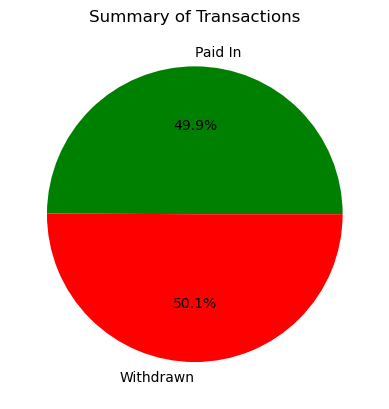

In [142]:
# Summarize paid in and withdrawn amounts
summary = data[['Paid In', 'Withdrawn']].sum()
summary.plot(kind='pie', autopct='%1.1f%%', colors=['green', 'red'], labels=['Paid In', 'Withdrawn'])
plt.title('Summary of Transactions')
plt.ylabel('')
plt.show()

## 3. Top 10 Sources of Incoming Payments and Withdrawals

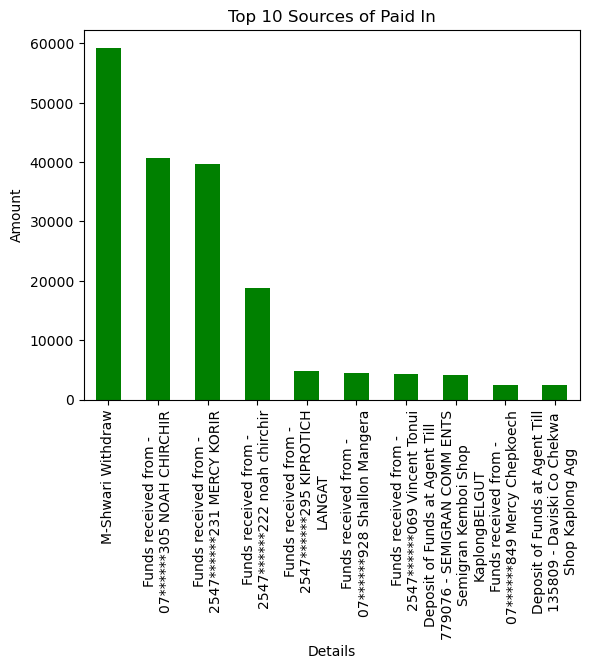

In [143]:
# Top 10 sources of Paid In
top_paid_in_sources = data.groupby('Details')['Paid In'].sum().nlargest(10)
top_paid_in_sources.plot(kind='bar', color='green')
plt.title('Top 10 Sources of Paid In')
plt.ylabel('Amount')
plt.show()



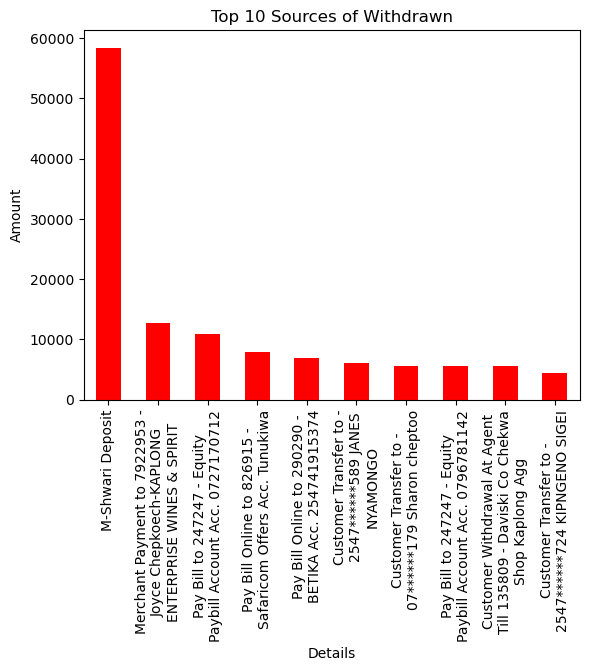

In [144]:
# Top 10 sources of Withdrawn
top_withdrawn_sources = data.groupby('Details')['Withdrawn'].sum().nlargest(10)
top_withdrawn_sources.plot(kind='bar', color='red')
plt.title('Top 10 Sources of Withdrawn')
plt.ylabel('Amount')
plt.show()

## 4. Query Transactions Above a Given Threshold

In [145]:
# Query for transactions above a given threshold (e.g., 10,000)
threshold = 10000
high_value_paid_in = data[data['Paid In'] > threshold].sort_values(by='Paid In', ascending=False)
high_value_withdrawn = data[data['Withdrawn'] > threshold].sort_values(by='Withdrawn', ascending=False)

# Display results
high_value_paid_in.head(), high_value_withdrawn.head()

(     Receipt No.                                           Details  Paid In  \
 4602  SD99MIE6HH  Funds received from -\n07******305 NOAH CHIRCHIR  12300.0   
 
       Withdrawn  Balance        Date      Time  
 4602        NaN  12715.0  2024-04-09  12:30:50  ,
 Empty DataFrame
 Columns: [Receipt No., Details, Paid In, Withdrawn, Balance, Date, Time]
 Index: [])

## 5. Query Transactions Related to a Specific Customer or Merchant

In [146]:
# Query for a specific customer or merchant
search_term = 'withdrawal'
filtered_data = data[data['Details'].str.contains(search_term, case=False, na=False)]
filtered_data.shape

(38, 7)

## 6. Balance Trend Over Time

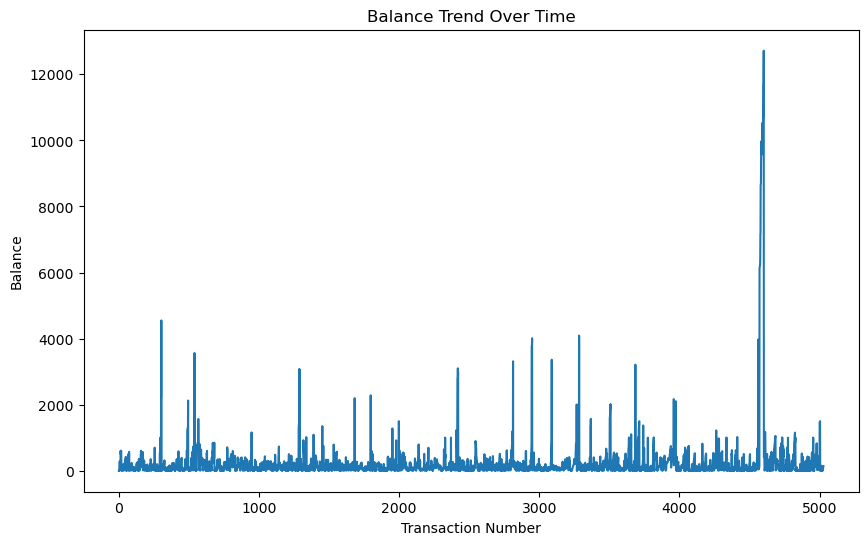

In [149]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x=range(len(data)), y="Balance")
plt.title("Balance Trend Over Time")
plt.xlabel("Transaction Number")
plt.ylabel("Balance")
plt.show()